In [60]:
from fktools import *
import tensorflow as tf
import sklearn

In [61]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(8,)),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(8, activation='softmax'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


latent_dim = 2
autoencoder = Autoencoder(latent_dim)

In [62]:
X = np.load("dataset_denoising_multiple_X.npz")['arr_0']
y = np.load("dataset_denoising_multiple_y.npz")['arr_0']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print(f"X train size: {X_train.shape}")
print(f"X test size: {X_test.shape}")

X shape: (58711, 8)
y shape: (58711, 8)
X train size: (46968, 8)
X test size: (11743, 8)


In [63]:
autoencoder.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.KLDivergence(),
)

history = autoencoder.fit(
    y_train, y_train,
    epochs=30,
    batch_size=32,
)

Epoch 1/30


1468/1468 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step - loss: 0.5157
Epoch 2/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.2637
Epoch 3/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 0.1725
Epoch 4/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.1215
Epoch 5/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.0921
Epoch 6/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - loss: 0.0733
Epoch 7/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 0.0617
Epoch 8/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 0.0556
Epoch 9/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.0526
Epoch 10/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - loss: 0.0510
Epoch 11/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - loss: 0.0502
Epoch 12/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - loss: 0.0497
Epoch 13/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 0.0495
Epoch 14/30
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.0493
Epoch 15/30


In [64]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

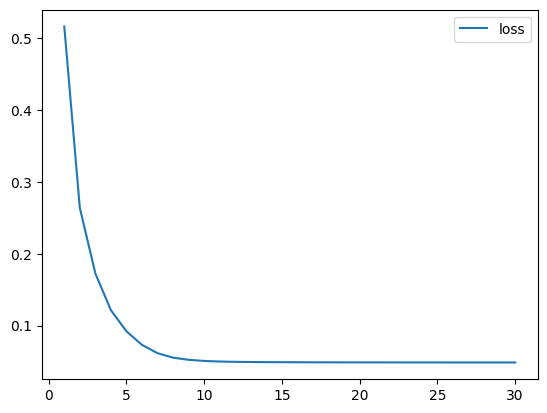

In [65]:

plt.plot(epochs, loss, label="loss")
plt.legend()

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step


<BarContainer object of 8 artists>

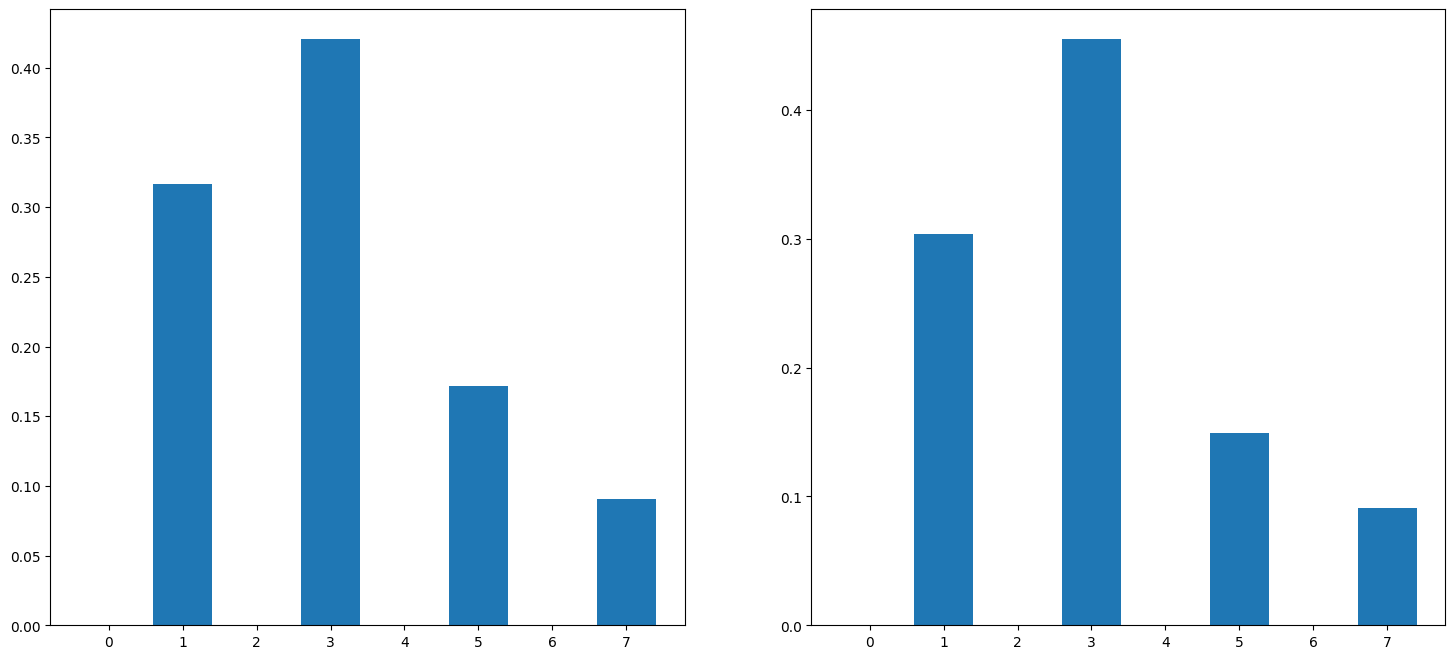

In [66]:
i = 1

pred = autoencoder.predict(y_test)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].bar(np.arange(8), y_test[i])
ax[1].bar(np.arange(8), pred[i])

[[1.8223962 7.238135 ]
 [9.6775055 2.051692 ]
 [1.7378646 8.904869 ]
 ...
 [9.346888  2.2682068]
 [1.7666728 5.426547 ]
 [2.5864677 6.2134433]]


Text(0.5, 1.0, 'autoencoder 8-2-8, encoded points')

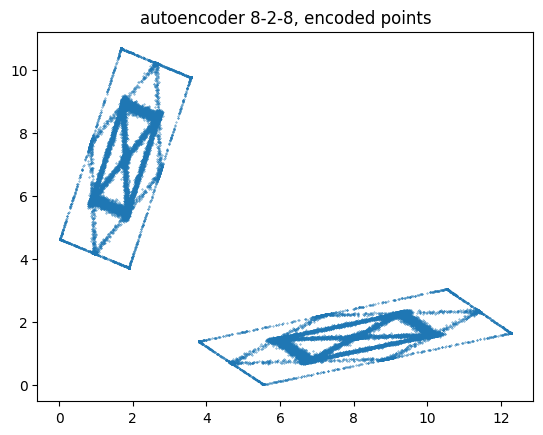

In [67]:
encoded_points = np.array(autoencoder.encoder(y))

print(encoded_points)

plt.scatter(encoded_points[:,0], encoded_points[:,1],s=0.1)
plt.title("autoencoder 8-2-8, encoded points")

In [68]:
print(tf.keras.losses.KLD(X_test, pred))
print(np.mean(tf.keras.losses.KLD(X_test, pred)))

tf.Tensor([0.1535999 4.2742176 3.4864707 ... 4.2960095 6.5598235 2.998738 ], shape=(11743,), dtype=float32)
3.9851315


In [69]:
autoX = np.load("dataset_autoenc_X.npz")['arr_0']
autoy = np.load("dataset_autoenc_y.npz", allow_pickle=True)['arr_0']
print(autoy[:,0])

[9 6 19 ... 21 9 13]


In [70]:
encoded_with_params = np.array(autoencoder.encoder(autoX))

Text(0.5, 1.0, 'color is number of steps')

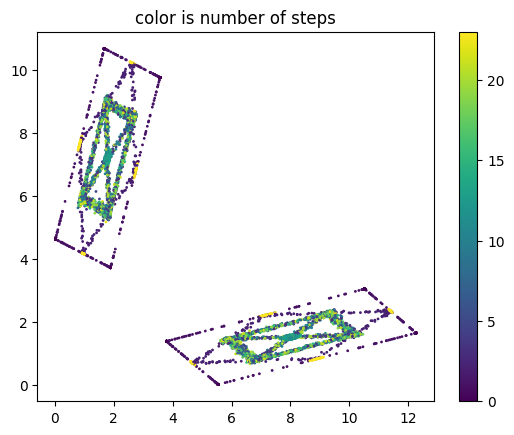

In [80]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=autoy[:,0])
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is number of steps')

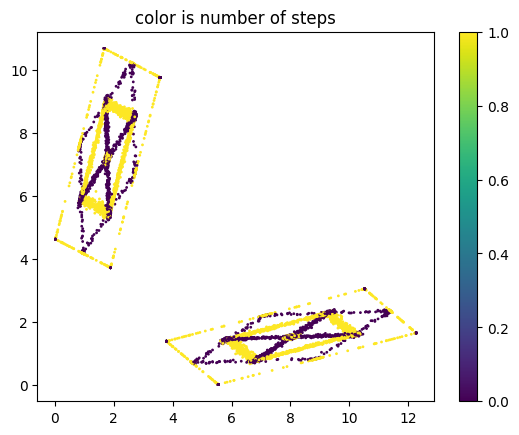

In [81]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=autoy[:,0]%2)
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is start position')

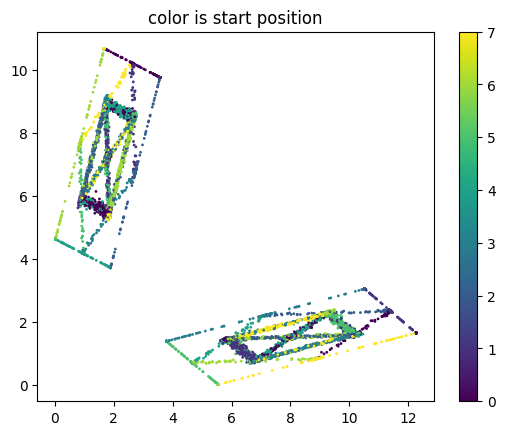

In [77]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=autoy[:,1])
plt.colorbar()
plt.title("color is start position")

Text(0.5, 1.0, 'color is coin phase')

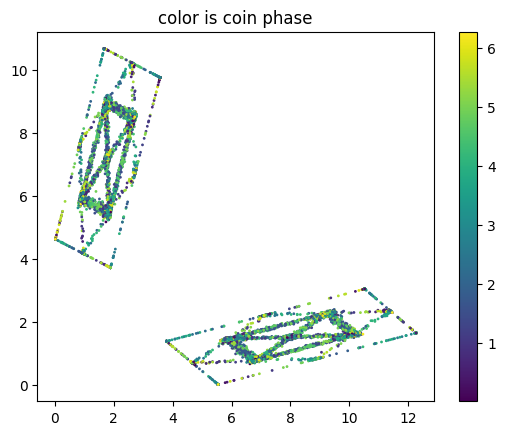

In [73]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=autoy[:,2])
plt.colorbar()
plt.title("color is coin phase")